In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import re
import os

from PIL import Image
from datetime import datetime

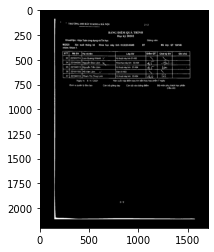

In [2]:
file_name = "2"
file_path = "./data/{}.jpg".format(file_name)

# Read image
img = cv2.imread(file_path, 0)

# Convert to binary image
thresh, img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
img_bin = ~img_bin

plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

In [3]:
# Define 2 kernels to detect vertical and horizontal lines
kernel_len = np.array(img).shape[1]//100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

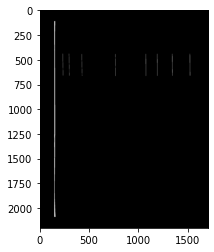

In [4]:
# Detect vertical lines
image_v = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_v, ver_kernel, iterations=3)

plotting = plt.imshow(image_v, cmap='gray')
plt.show()

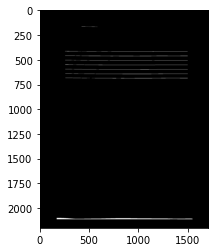

In [5]:
# Detect horizontal lines
image_h = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_h, hor_kernel, iterations=3)

plotting = plt.imshow(image_h, cmap='gray')
plt.show()

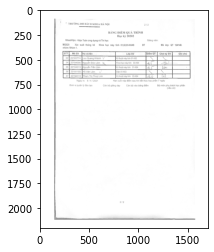

In [6]:
# Combine vertical and horizontal lines
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh, 128, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)

bitxor = cv2.bitwise_xor(img, img_vh)
bitnot = cv2.bitwise_not(bitxor)

plotting = plt.imshow(bitnot, cmap='gray')
plt.show()

In [7]:
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [8]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b : b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

In [9]:
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)

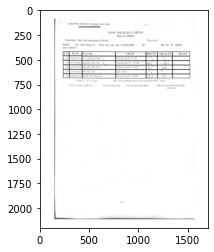

In [10]:
# Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w < 900 and h < 400):
        image = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        box.append([x, y, w, h])
        
plotting = plt.imshow(image, cmap='gray')
plt.show()

In [11]:
# Creating two lists to define row and column in which cell is located
row = []
column= []
j = 0
# Sorting the boxes to their respective row and column
for i in range(len(box)):
    if(i == 0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
print(column)
print(row)

[[233, 419, 58, 41], [295, 420, 125, 41], [424, 421, 333, 42], [1333, 422, 174, 41], [1182, 422, 147, 41], [1068, 422, 110, 41], [761, 423, 303, 41], [296, 464, 124, 43], [233, 464, 59, 41], [424, 466, 334, 43], [1334, 467, 173, 41], [1182, 467, 147, 41], [1068, 467, 110, 42], [761, 467, 303, 42], [296, 509, 125, 43], [234, 509, 58, 41], [425, 511, 333, 43], [1334, 512, 173, 41], [1183, 512, 147, 41], [1069, 512, 109, 42], [762, 513, 302, 41], [297, 555, 124, 42], [234, 555, 59, 41], [425, 556, 334, 43], [1334, 557, 174, 41], [1183, 557, 147, 41], [1069, 558, 110, 41], [762, 558, 303, 41], [297, 600, 125, 43], [235, 600, 59, 41], [1335, 602, 173, 41], [1183, 602, 147, 41], [426, 602, 333, 42], [1069, 603, 110, 41], [763, 603, 302, 41], [298, 645, 125, 40], [235, 645, 59, 39], [1335, 647, 173, 39], [1183, 647, 148, 40], [427, 647, 332, 40], [1069, 648, 110, 39], [763, 648, 302, 40]]
[[[393, 165, 211, 9]], [[233, 419, 58, 41], [295, 420, 125, 41], [424, 421, 333, 42], [1333, 422, 174, 41

In [12]:
# Calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

In [13]:
# Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

In [14]:
# Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    lis = []
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center - (row[i][j][0] + row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

In [15]:
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg
from vietocr.tool.detector import predict

In [16]:
config = Cfg.load_config_from_name('vgg_transformer')
# config['device'] = 'cpu'
config['device'] = 'cuda:0'

In [17]:
detector = Predictor(config)

File exists: C:\Users\DT\.cache/gdown\https-COLON--SLASH--SLASH-drive.google.com-SLASH-uc-QUESTION-id-EQUAL-13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA


In [18]:
count_time = datetime(1,1,1,0,0)
# From every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer = []
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner = ''
        if(len(finalboxes[i][j]) == 0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg ,2, 2, 2, 2, cv2.BORDER_CONSTANT, value=[255, 255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation = cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel, iterations=1)
                erosion = cv2.erode(dilation, kernel, iterations=1)
                
                erosion = Image.fromarray(erosion)
                start = datetime.now()
                out = detector.predict(erosion)
                count_time += datetime.now() - start
                out = out.replace('\n','')
                out = out.replace('\r','')
                out = out.replace('\t','')
                out = out.replace(' ','')
            
                inner = inner +" "+ out
            outer.append(inner)
print(count_time)

0001-01-01 00:00:05.693044


In [19]:
# Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
df = dataframe

In [20]:
# Post-processing
index = 0
while df[0][index].strip() != 'STT':
    df = df.drop(index, axis = 0)
    index += 1

df = df.reset_index(drop=True)
df = df.rename(columns=df.iloc[0]).drop(df.index[0])

df.iloc[:, -2:] = ''
for i, value in enumerate(df.iloc[:, -3]):
    if not value.strip()[0].isdigit():
        df.iloc[i, -3] = ''
    elif ',' in value:
        df.iloc[i, -3] = df.iloc[i, -3].replace(',', '.')
    elif '.' not in value:
        df.iloc[i, -3] = df.iloc[i, -3][:-1] + '.' + df.iloc[i, -3][-1:]

for i in range(len(df)):
    if df.iloc[i, 0].strip() == '':
        if i == 0:
            df.iloc[i, 0] = 1
        else:
            df.iloc[i, 0] = str(int(df.iloc[i-1, 0]) + 1)

KeyError: 2

In [ ]:
df

In [ ]:
# Converting it in a excel-file
df.to_excel("out/{}_out.xlsx".format(file_name), index=False)